<span style="color:#1f77b4; font-size:24px; font-weight:bold;">BRITISH AIRWAYS AIRLINES REVIEW ANALYSIS USING NLP LABS</span>  
<span style="color:#1f77b4; font-size:18px;">LASYA BODAPATI, 04/14/25</span>


## **PART 1 - WEB SCRAPPING FROM SKYTRAX**

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
from pathlib import Path

*using python libraries to gather the required data for analysis*

In [ ]:
# Path to Downloads folder
downloads_path = str(Path.home() / "Downloads")
file_path = os.path.join(downloads_path, "british_airways_reviews.csv")

# Base URL (British Airways, sorted by latest)
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/page/{}/?sortby=post_date%3ADesc"

all_reviews = []
num_pages = 10

for page in range(1, num_pages + 1):
    url = base_url.format(page)
    print(f"Scraping page {page}: {url}")
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")

    review_blocks = soup.find_all("article", itemprop="review")

    for review in review_blocks:
        try:
            title = review.find("h2", class_="text_header").text.strip()
            content = review.find("div", class_="text_content").text.strip()
            date = review.find("time")["datetime"]

            # Rating: find the span with itemprop='ratingValue'
            rating_span = review.find("span", itemprop="ratingValue")
            rating = int(rating_span.text.strip()) if rating_span else None

            #Recommendation logic
            recommended = "Yes" if " Trip Verified" in review.text and "Not Recommended" not in review.text else "No"

            all_reviews.append({
                "Title": title,
                "Review": content,
                "Date": date,
                "Rating (out of 10)": rating,
                "Recommended": recommended
            })
        except Exception as e:
            print("Error parsing a review:", e)

    time.sleep(2)

# Save to CSV
df = pd.DataFrame(all_reviews)
df.to_csv(file_path, index=False)
print(f"Scraping complete. CSV saved to: {file_path}")


## **PART 2 - PERFORMING NLP TASKS AND TOPIC MODELLING**

## **STEP 1 - LOAD AND CLEAN THE DATA**

In [3]:
import pandas as pd

#load the dataset and make a subset that has reviews 
df = pd.read_csv(r"C:\Users\lasya\Downloads\british_airways_reviews.csv")
df.dropna(subset=["Review"],inplace = True)

#preview 
df.head()

,Title,Review,Date,Rating (out of 10),Recommended
0,"""checkin was very rude to us""",✅ Trip Verified | The employee at Venice Air...,4/13/2025,3,Yes
1,"""forced to check-in carry-ons""","✅ Trip Verified | I had only 1 bag with me, ...",4/12/2025,1,Yes
2,“Pleasant cabin crew”,✅ Trip Verified | Check in and security at T5 ...,4/9/2025,7,Yes
3,"""one of the best BA First flights I’ve had""",Not Verified | LHR T5 BA Gold Wing worked wel...,4/3/2025,9,No
4,"""Very good service on this route""",Not Verified | Very good service on this rout...,3/31/2025,10,No


## **STEP 2: TEXT PROCESSING** 

*text needs to be processed and cleaned for better understanding.*

*Stopwords are those that do not carry significant meaning - a, the, is*

*Lemmatizer ensures words are filtered down to short dictionary terms*

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lasya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lasya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lasya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import spacy
import re

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Custom clean function
def clean_text_spacy(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Apply to your reviews
df["Clean_Review"] = df["Review"].astype(str).apply(clean_text_spacy)

# Display sample cleaned output
df[["Review", "Clean_Review"]].head()


,Review,Clean_Review
0,✅ Trip Verified | The employee at Venice Air...,trip verify employee venice airport chec...
1,"✅ Trip Verified | I had only 1 bag with me, ...",trip verify bag carry trolley boarding...
2,✅ Trip Verified | Check in and security at T5 ...,trip verify check security t quick gallery...
3,Not Verified | LHR T5 BA Gold Wing worked wel...,verify lhr t ba gold wing work pleasant che...
4,Not Verified | Very good service on this rout...,verify good service route ba th march cabin...


## **STEP 3: SENTIMENT ANALYSIS USING VADER**

*using vader a rough diffrenciation between reviews is done on 3 labels - neutral, negative, positive*

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Get sentiment scores
df["Sentiment_Score"] = df["Review"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Label sentiment
df["Sentiment_Label"] = df["Sentiment_Score"].apply(lambda score: 
    "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral")

# View sentiment distribution
df["Sentiment_Label"].value_counts()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lasya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment_Label
Negative    59
Positive    39
Neutral      2
Name: count, dtype: int64

## **STEP 4: WORDCLOUD FOR REVIEWS**

*most frequently used words by the customers in their reviews, dropping some obvious words like airlines, flight etc. for depth*

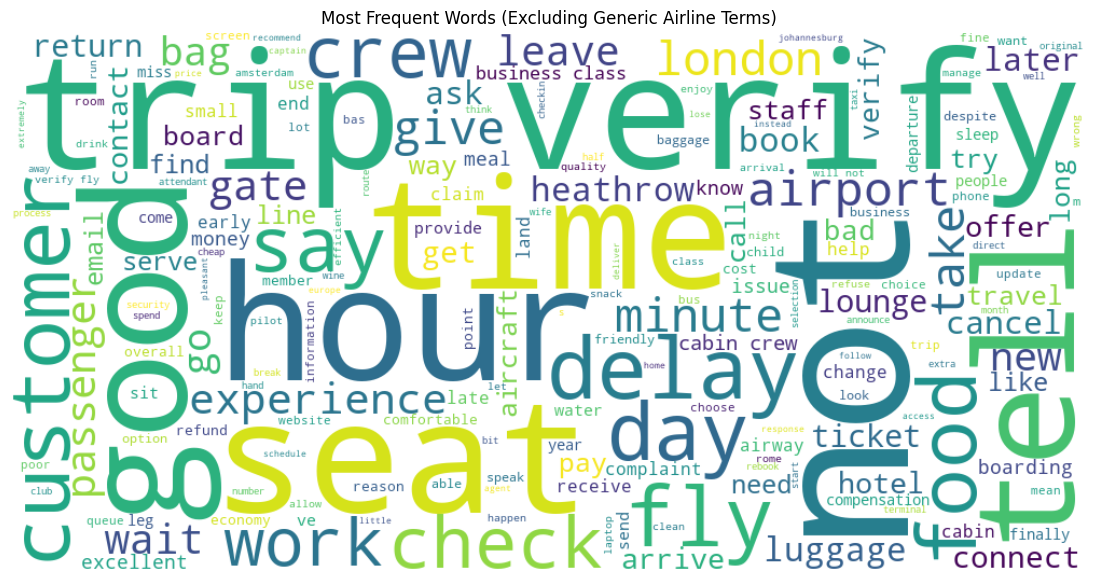

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define custom stopwords
custom_stopwords = {"airline", "flight", "ba", "british", "airways", "service", "plane"}

# Combine all cleaned text
all_text = " ".join(df["Clean_Review"])

# Generate wordcloud with custom stopwords
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    stopwords=custom_stopwords
).generate(all_text)

# Plot the wordcloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words (Excluding Generic Airline Terms)")
plt.show()


## **STEP 5: TOPIC MODELLING** 

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert text into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df["Clean_Review"])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(dtm)

# Get topic keywords
words = vectorizer.get_feature_names_out()

for i, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[-10:]]
    print(f"🔹 Topic #{i+1}: {' | '.join(top_words)}")


🔹 Topic #1: service | cabin | time | trip | ba | food | crew | flight | seat | good
🔹 Topic #2: customer | day | ba | trip | tell | service | delay | british | hour | flight
🔹 Topic #3: johannesburg | leg | say | ticket | change | rome | book | tell | ba | flight
🔹 Topic #4: british | airways | experience | world | trip | flight | fly | airline | service | ba


## **PART 3 - CUSTOMER BOOKING ANALYSIS**

*Build a machine learning model that predicts whether a customer will complete a booking (booking_complete = 1)*

*based on their travel preferences, booking habits, and other features.*

**setting up the environment for building a predictive model - random forest model**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

**loading the dataset, dropping unnecessary columns, splitting the data to train and test for further evaluation**

In [12]:
df = pd.read_csv(r"C:\Users\lasya\Downloads\customer_booking.csv", encoding="ISO-8859-1")

df = df.drop(columns=["route", "booking_origin"])  # too many unique values

df = pd.get_dummies(df, columns=["sales_channel", "trip_type", "flight_day"], drop_first=True)

X = df.drop("booking_complete", axis=1)
y = df["booking_complete"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed
0,2,262,19,7,1,0,0,5.52,0,False,False,True,False,True,False,False,False,False
1,1,112,20,3,0,0,0,5.52,0,False,False,True,False,True,False,False,False,False
2,2,243,22,17,1,1,0,5.52,0,False,False,True,False,False,False,False,False,True
3,1,96,31,4,0,0,1,5.52,0,False,False,True,False,True,False,False,False,False
4,2,68,22,15,1,0,1,5.52,0,False,False,True,False,False,False,False,False,True


**building a random forest model**

In [18]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


[0 0 0 ... 0 0 0]


In [16]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


[[8402  118]
 [1389   91]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.44      0.06      0.11      1480

    accuracy                           0.85     10000
   macro avg       0.65      0.52      0.51     10000
weighted avg       0.80      0.85      0.80     10000

Accuracy: 0.8493


C:\Users\lasya\AppData\Local\Temp\ipykernel_23068\3756313460.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[:10], y=feature_importance.index[:10], palette='Blues_r')


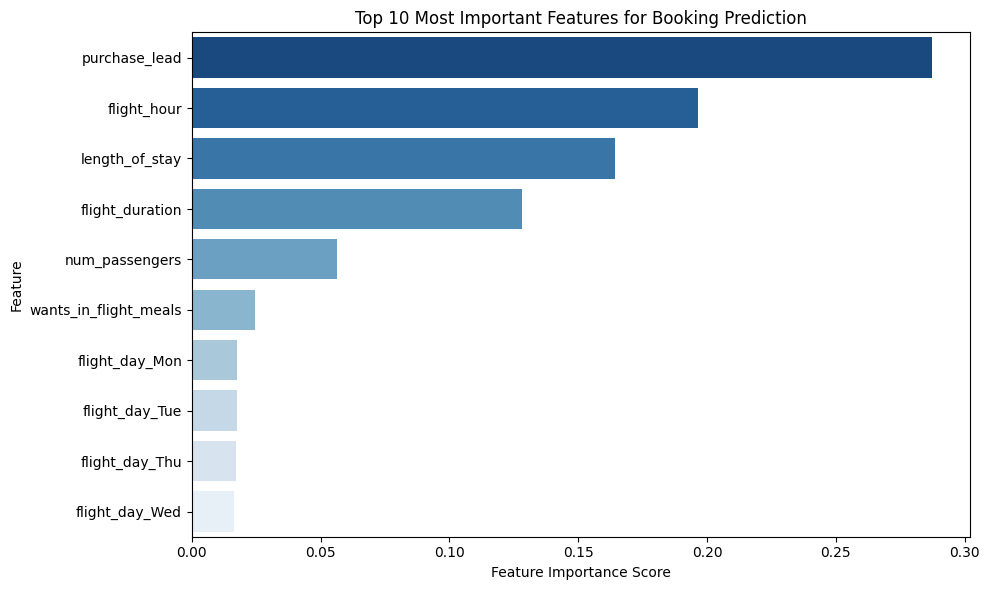

In [17]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[:10], y=feature_importance.index[:10], palette='Blues_r')
plt.title("Top 10 Most Important Features for Booking Prediction")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**from the above analysis, the most important feature that determine a customers' complete booking is purchase_lead which means the number of days the ticket was booked in advance**